# Triple Barrier Labeling
1. Load the price data
2. Volatility calculation and event extraction
3. Fixed time horizon labeling
4. Triple barrier labeling
5. Confirmation labeling
6. Plotting and visualization

In [1]:
import pandas as pd
from typing import List, Callable
from functools import partial
from tqdm.notebook import tqdm  # Use notebook version of tqdm for better compatibility with Jupyter
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.patches as patches
from pandas.tseries.offsets import DateOffset
import plotly.graph_objects as go
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import vectorbt as vbt
from matplotlib.ticker import MaxNLocator
import mplfinance as mpf
from scipy.optimize import minimize

In [2]:
plt.style.use('default')

### Load the price data

In [3]:
price_df = pd.read_csv("../raw/daily-2020.csv", usecols=["timestamp", "close", "open", "high", "low", "volume"])
price_df.set_index('timestamp', inplace=True)
price_df.index = pd.to_datetime(price_df.index, unit='s')

### Volatility calculation and event extraction

In [4]:
def get_volatility_and_return(close, span=30):
    """
    Calculate the EWMA volatility of closing prices.
    
    Parameters:
    - close: A pandas Series of closing prices.
    - span: The span for the EWMA standard deviation.
    
    Returns:
    - A pandas Series of EWMA volatility estimates.
    """
    # Calculate log returns
    log_returns = np.log(close / close.shift(1))
    
    # Calculate EWMA volatility
    ewma_volatility = log_returns.ewm(span=span).std()
    
    return log_returns, ewma_volatility

In [5]:
price_df["daily_returns"], price_df["volatility"] = get_volatility_and_return(price_df.close)

In [6]:
price_df.dropna(inplace=True)

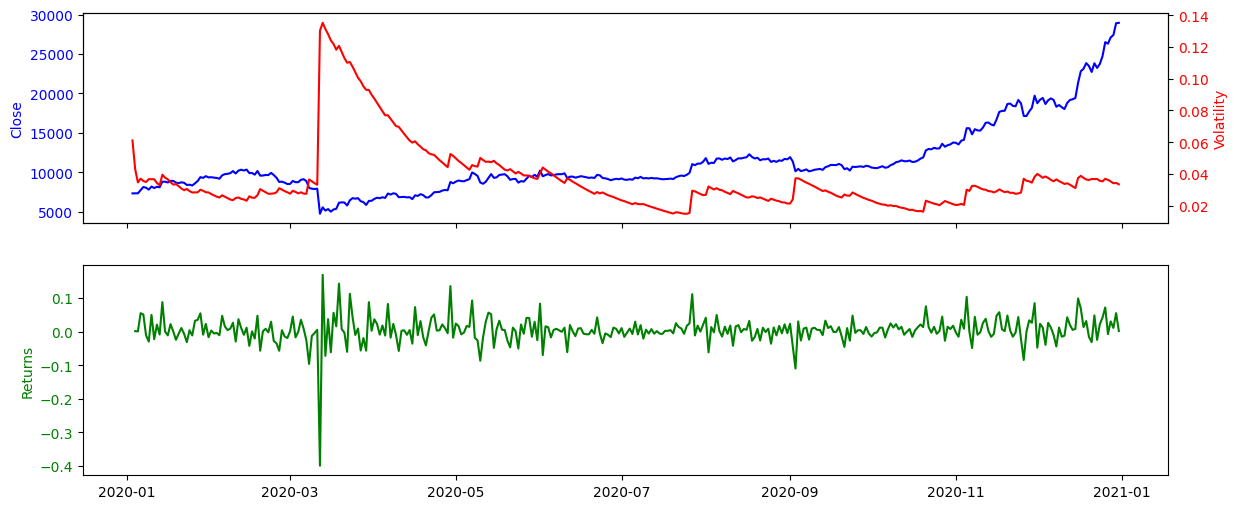

In [7]:
# Calculate returns
price_df['returns'] = price_df['close'].pct_change()

# Create a new figure with two subplots
fig, (ax1, ax3) = plt.subplots(2, 1, sharex=True, figsize=(14, 6))

# Plot 'close' on the primary y-axis of the first subplot
ax1.plot(price_df.index, price_df['close'], color='blue')
ax1.set_ylabel('Close', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis for 'volatility' on the first subplot
ax2 = ax1.twinx()
ax2.plot(price_df.index, price_df['volatility'], color='red')
ax2.set_ylabel('Volatility', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Plot 'returns' on the second subplot
ax3.plot(price_df.index, price_df['returns'], color='green')
ax3.set_ylabel('Returns', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# Show the plot
plt.show()

In [8]:
def get_t_events(raw_price, volatility, base_threshold):
    """
    :param raw_price: (series) of close prices.
    :param volatility: (series) of volatility values.
    :param base_threshold: (float) base level for the threshold.
    :return: (datetime index vector) vector of datetimes when the events occurred. This is used later to sample.
    """
    print('Applying Symmetric CUSUM filter.')

    t_events, s_pos, s_neg = [], 0, 0

    # log returns
    diff = np.log(raw_price).diff().dropna()

    # Get event time stamps for the entire series
    for i in tqdm(diff.index[1:]):
        # Adjust the threshold based on volatility
        threshold = base_threshold * volatility.loc[i]
        
        s_pos = max(0.0, float(s_pos + diff.loc[i]))
        s_neg = min(0.0, float(s_neg + diff.loc[i]))

        if s_neg < -threshold:
            s_neg = 0
            t_events.append(i)

        elif s_pos > threshold:
            s_pos = 0
            t_events.append(i)

    event_timestamps = pd.DatetimeIndex(t_events)
    return event_timestamps

In [9]:
events = get_t_events(price_df.close, price_df.volatility, 1.5)

Applying Symmetric CUSUM filter.


  0%|          | 0/362 [00:00<?, ?it/s]

In [10]:
price_df["event"] = price_df.index.isin(events)

In [11]:
price_df

,open,high,low,close,volume,daily_returns,volatility,returns,event
timestamp,,,,,,,,,
2020-01-03,6962.34,7407.28,6863.44,7341.72,208493.458,0.053101,0.061074,NaN,False
2020-01-04,7341.60,7400.00,7269.21,7350.71,92586.033,0.001224,0.042874,0.001225,False
2020-01-05,7350.54,7495.00,7303.00,7354.36,117765.972,0.000496,0.034615,0.000497,False
2020-01-06,7354.36,7808.65,7345.00,7757.39,168150.317,0.053353,0.036972,0.054802,False
2020-01-07,7757.74,8215.33,7733.00,8152.49,280809.162,0.049677,0.035543,0.050932,True
...,...,...,...,...,...,...,...,...,...
2020-12-27,26508.84,28459.84,25850.00,26305.64,540264.148,-0.007695,0.036219,-0.007665,False
2020-12-28,26301.76,27538.82,26117.10,27102.66,267563.468,0.029849,0.035223,0.030298,False
2020-12-29,27101.45,27441.73,25913.01,27402.83,260759.449,0.011014,0.034092,0.011075,False


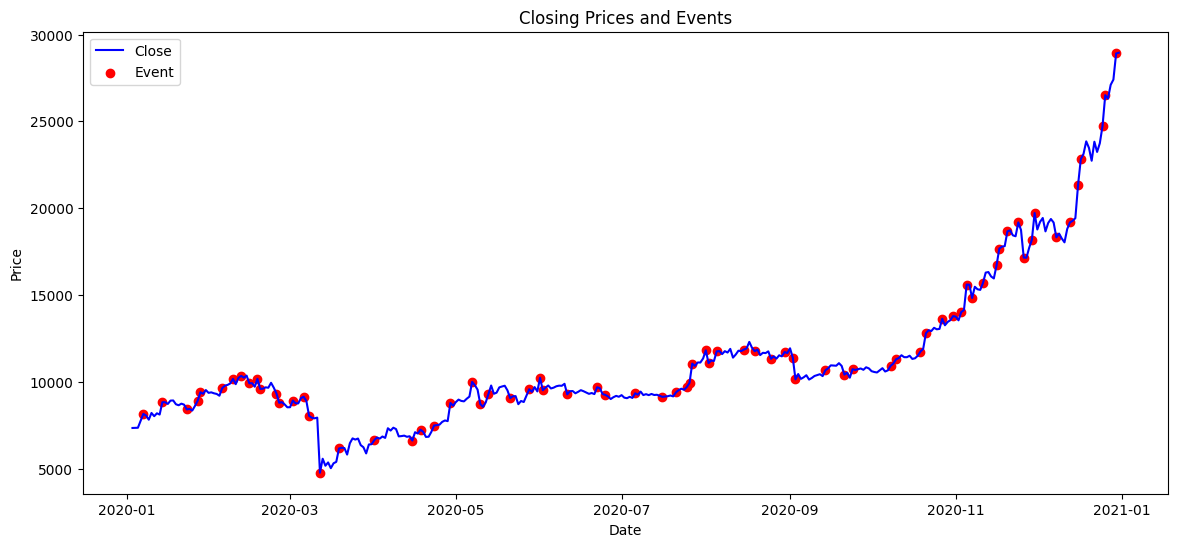

In [12]:
# Plot the closing prices
plt.subplots(figsize=(14, 6))
plt.plot(price_df.index, price_df['close'], color='blue', label='Close')

# Add dots for the event dates
plt.scatter(events, price_df.loc[events, 'close'], color='red', label='Event')

# Set the labels and title
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Closing Prices and Events')
plt.legend()

# Show the plot
plt.show()

### Fixed time horizon labeling

In [13]:
def fixed_time_horizon_labeling(price_series, h):
    """
    Perform fixed time horizon labeling on a price series.
    
    Parameters:
    - price_series: A pandas Series of prices.
    - h: The bar horizon.
    
    Returns:
    - A pandas Series of labels (-1, 0, 1).
    """
    # Split the price series into non-overlapping windows of size h
    windows = [price_series[i:i+h] for i in range(0, len(price_series), h)]
    
    # Initialize an empty list to store the labels
    labels = []
    
    # For each window, compare the last item with the first item and assign a label accordingly
    for window in windows:
        # print("last candle in window: ", window.iloc[-1], "first candle in window: ", window.iloc[0], window.iloc[-1] > window.iloc[0])
        if len(window) == h:  # Ensure the window is of size h
            if window.iloc[-1] > window.iloc[0]:
                labels.extend([1]*h)  # Bullish
            elif window.iloc[-1] < window.iloc[0]:
                labels.extend([-1]*h)  # Bearish
            else:
                labels.extend([0]*h)  # Neutral
    
    # Convert the list of labels into a pandas Series
    labels = pd.Series(labels, index=price_series.index[:len(labels)])
    
    return labels

In [14]:
def band_generator(labels):
    bands = [{'label': labels.iloc[0], 'from': labels.index[0]}]
    for l, i in enumerate(labels):
        if i == bands[-1]["label"]:
            pass
        else:
            bands[-1]["to"] = labels.index[l]
            # Check if l + 1 is within the range of the labels' indices
            if l + 1 < len(labels):
                bands.append({'label': i, 'from': labels.index[l + 1]})
    
    # Check if the last band has a 'to' field
    if 'to' not in bands[-1]:
        bands[-1]['to'] = labels.index[-1]
    
    return bands

In [17]:
def plot_labels(price_series, labels):
    """
    Plot price series with bullish and bearish areas.
    
    Parameters:
    - price_series: A pandas Series of prices.
    - labels: A pandas Series of labels (-1, 0, 1).
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()
    
    # Plot the price series
    ax1.plot(price_series.index, price_series.values, label='Price', color='black')
    
    # Draw a box for each window
    for label in labels:
        # Shift "from" and "to" by half a day
        from_timestamp = label["from"] - DateOffset(hours=12)
        to_timestamp = label["to"] + DateOffset(hours=12)
        
        # Ensure the timestamps are within the price series index
        from_timestamp = max(from_timestamp, price_series.index[0])
        to_timestamp = min(to_timestamp, price_series.index[-1])
        
        # Add the band
        ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color='green' if label["label"] == 1 else "red" if label["label"] == -1 else 'white' , alpha=0.2)

    # Add a legend
    ax1.legend()
    
    # Show the plot
    plt.show()

In [34]:
plt_df = price_df["2020-08-01":"2020-11-01"]

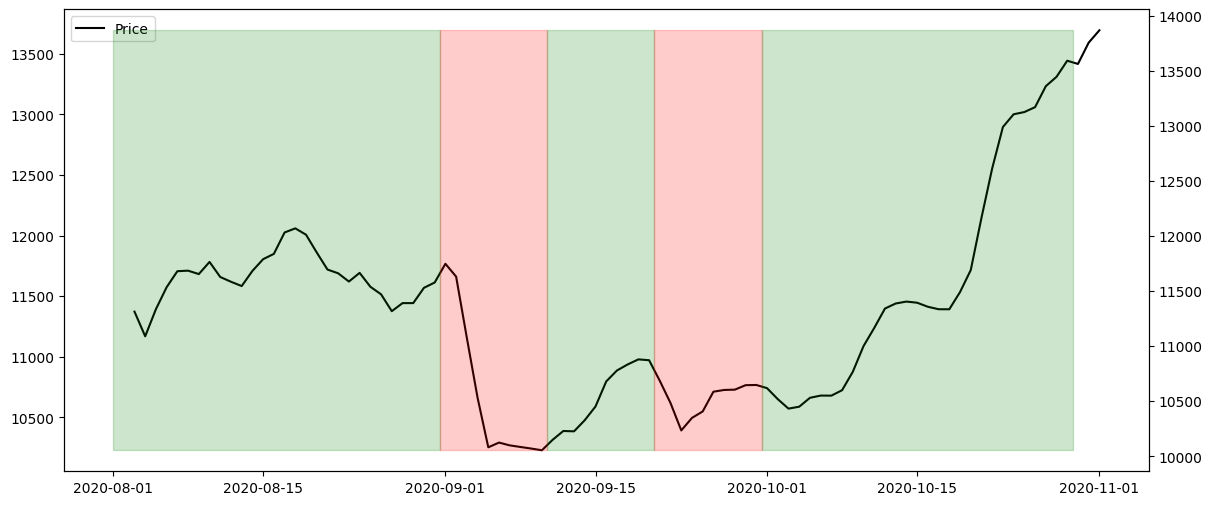

In [37]:
labels = fixed_time_horizon_labeling(plt_df.close, 10)
bands = band_generator(labels)
plot_labels(plt_df.close.rolling(3).mean(), bands)

In [25]:
labels.value_counts()

 1    240
-1    120
Name: count, dtype: int64

In [26]:
price_df["labels"] = labels

### Triple barrier labeling

In [14]:
# Define labels as named constants for readability
LABEL_UP = 1
LABEL_DOWN = -1
LABEL_NEUTRAL = 0

In [15]:
def calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type='volatility'):
    end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

    # Calculate the mean volatility or daily returns over the volatility_period
    if barrier_type == 'volatility':
        mean_value = df.loc[i-volatility_period+1:i, 'volatility'].mean()
        current_value = df.loc[i, 'volatility']
    elif barrier_type == 'returns':
        mean_value = df.loc[i-volatility_period+1:i, 'daily_returns'].mean()
        current_value = df.loc[i, 'daily_returns']
    else:
        raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

    df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * upper_barrier_factor)
    df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * lower_barrier_factor)
    return df

In [16]:
def label_observations(df, origin, i, label):
    df.loc[origin:i+1, 'labels'] = label
    return df

In [17]:
def triple_barrier_labeling(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL"):
    df = sdf.copy()
    df = df.reset_index()
    
    # Initialize labels and window start
    df['labels'] = LABEL_NEUTRAL
    df['window_start'] = False

    window = vertical_barrier
    origin = 0
    touch_upper = lambda high, barrier: high >= barrier
    touch_lower = lambda low, barrier: low <= barrier
    # For each observation
    for i in range(0, len(df)):
        # Define your barriers at the beginning of each window
        if i == origin:
            df = calculate_barriers(df, i, window, upper_barrier_factor, lower_barrier_factor, volatility_period, barrier_type)
            df.loc[i, 'window_start'] = True  # Mark the start of the window

        # one of the conditions were met
        if touch_upper(df.loc[i, "high" if touch_type == 'HL' else 'close'], df.loc[i, "upper_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_UP)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier
        elif touch_lower(df.loc[i, "low" if touch_type == 'HL' else 'close'], df.loc[i, "lower_barrier"]):
            if (i - origin > min_trend_days):
                # label the observations
                df = label_observations(df, origin, i, LABEL_DOWN)
                # set new origin
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index
                # reset window
                window = vertical_barrier

        # none of the conditions were met
        else:
            if window > 0:
                # reduce window size by one
                window = window - 1
            else:
                # reset window
                window = vertical_barrier
                # label neutral from origin to origin + window
                df.loc[origin:min(origin+window, len(df)-1), 'labels'] = LABEL_NEUTRAL  # Ensure the window does not exceed the dataframe
                # set origin to the next id
                origin = i + 1 if i + 1 < len(df) else i  # Check if i + 1 is within the DataFrame's index

    df = df.set_index("timestamp")
    return df

In [18]:
tbl_df = triple_barrier_labeling(price_df, volatility_period=10, upper_barrier_factor=1.5, lower_barrier_factor=1.2, vertical_barrier=7, min_trend_days=2, barrier_type='volatility')

In [19]:
tbl_df.labels.value_counts()

labels
 1    180
 0    101
-1     83
Name: count, dtype: int64

In [20]:

def plot_triple_barrier(df,loc=1,sample_point_index=10, start_index = 0, n_days = 100 ,time_out = 20 ):
  """
    parameters :
      loc = 1 => position of smaller plot up
      loc = 2 => position of smaller plot down
      sample_point_index : the point which is going to show the labelling details
      time_out : how many next day's data are used for labeling of each point
  """
  price = df.close.to_numpy()[start_index:start_index+n_days]
  # Set initial barriers
  profit_taking = 1.0  # Multiplier for the volatility adjustment
  stop_loss = 1.0  # Multiplier for the volatility adjustment

  # Calculate rolling volatility (standard deviation)
  window = 10  # Window size for rolling calculation
  rolling_volatility = pd.Series(price).rolling(window=window).std().fillna(0)

  # Initialize arrays to hold the barrier values
  upper_barrier = np.zeros(n_days)
  lower_barrier = np.zeros(n_days)

  # Initialize arrays to hold labels
  high_points = np.zeros(n_days, dtype=bool)
  low_points = np.zeros(n_days, dtype=bool)
  neutral_points = np.zeros(n_days, dtype=bool)

  # Iterate over each day to calculate barriers and labels
  for i in range(n_days):
      if i + time_out < n_days:
          future_prices = price[i:i + time_out]
          upper_barrier[i] = price[i] + (profit_taking * rolling_volatility[i])
          lower_barrier[i] = price[i] - (stop_loss * rolling_volatility[i])

          # Check if any future price crosses the barriers
          if np.any(future_prices >= upper_barrier[i]):
              high_points[i] = True
          elif np.any(future_prices <= lower_barrier[i]):
              low_points[i] = True
          else:
              neutral_points[i] = True
      else:
          upper_barrier[i] = np.nan
          lower_barrier[i] = np.nan
          neutral_points[i] = True

  # Plot the stock prices and barriers
  fig, ax = plt.subplots(figsize=(14, 7))
  ax.plot(price, label='Stock Price', color='blue')
  ax.plot(upper_barrier, color='green', linestyle='--', label='Profit Taking Barrier (Volatility Adjusted)')
  ax.plot(lower_barrier, color='red', linestyle='--', label='Stop Loss Barrier (Volatility Adjusted)')
  ax.axvline(time_out, color='purple', linestyle='--', label='Time Out Barrier')

  # Highlight high, low, and neutral points
  ax.scatter(np.where(high_points)[0], price[high_points], color='green', marker='^', label='High Points')
  ax.scatter(np.where(low_points)[0], price[low_points], color='red', marker='v', label='Low Points')
  ax.scatter(np.where(neutral_points)[0], price[neutral_points], color='orange', marker='o', label='Neutral Points')

  # Adding labels and title
  ax.set_xlabel('Days')
  ax.set_ylabel('Price')
  ax.set_title('Stock Prices with Volatility-Adjusted Triple Barrier and Points Classification')
  ax.legend()
  ax.grid(True)



  if sample_point_index is not np.nan:
      if loc == 1:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=9)
      else:
        inset_ax = inset_axes(ax, width="25%", height="25%", loc=8)

      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), price[sample_point_index:sample_point_index + time_out], label='Stock Price', color='blue')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, upper_barrier[sample_point_index]), color='green', linestyle='--', label='Upper Barrier')
      inset_ax.plot(range(sample_point_index, sample_point_index + time_out), np.full(time_out, lower_barrier[sample_point_index]), color='red', linestyle='--', label='Lower Barrier')
      inset_ax.grid(True)

      if loc == 1 :
        pos = (0.5, 0.9)
      else :
        pos = (0.3, 0.3)

      ax.annotate('',
                  xy=(sample_point_index, price[sample_point_index]),
                  xycoords='data',
                  xytext=pos,
                  textcoords='axes fraction',
                  arrowprops=dict(facecolor='black', shrink=0.05, width=0.5, headwidth=5),
                  horizontalalignment='right', verticalalignment='bottom')

  plt.show()

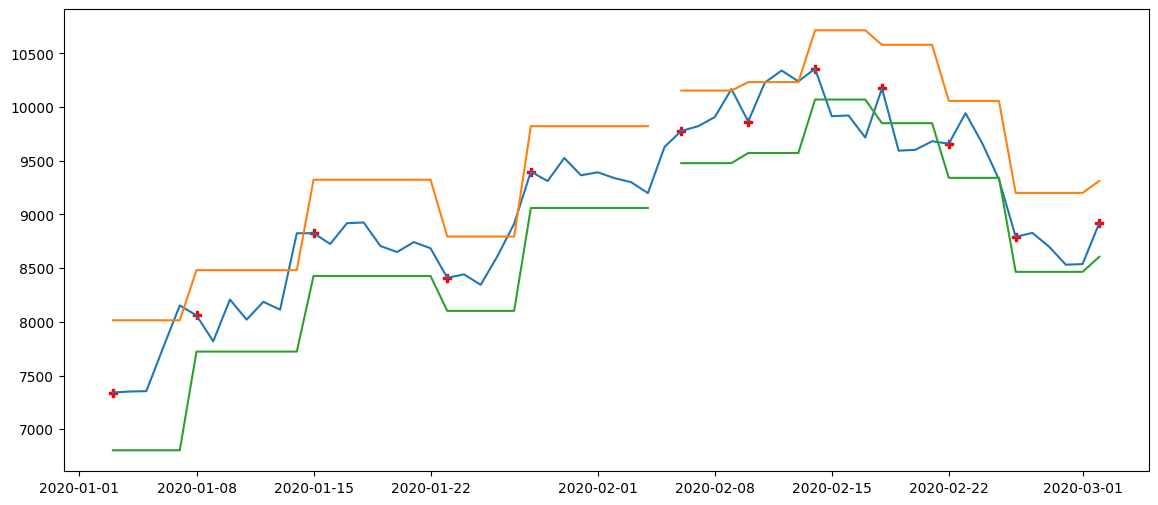

In [21]:
plot_df = tbl_df[0:60]
# Create a new DataFrame where 'window_start' is True
window_starts = plot_df[plot_df['window_start']]

plt.subplots(figsize=(14, 6))

# Plot the 'close', 'upper_barrier', and 'lower_barrier' columns
plt.plot(plot_df.index, plot_df[['close', 'upper_barrier', 'lower_barrier']], ms=1)

# Add markers at the start of each window
plt.scatter(window_starts.index, window_starts['close'], color='red', marker="P")

plt.show()

In [22]:
tbl_df.shape

(364, 13)

In [23]:
prices = tbl_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

NameError: name 'band_generator' is not defined

### Confirmations labeling

In [24]:
def market_confirmed_labels(sdf, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7):
    """
    Calculate market confirmed labels.
    
    Parameters:
    - df: A pandas DataFrame with 'close', 'volatility', 'high', and 'low' columns.
    - volatility_period: The number of periods used to calculate volatility.
    - upper_barrier_factor: The factor used to calculate the upper barrier.
    - lower_barrier_factor: The factor used to calculate the lower barrier.
    - vertical_barrier: The size of the window.
    """
    df = sdf.reset_index()
    # Initialize labels and window start
    df['up_confirmed'] = False
    df['down_confirmed'] = False
    df['neutral_confirmed'] = False
    df['window_start'] = False

    # Calculate barriers and labels for each window
    for i in range(volatility_period, len(df)):
        # Calculate the mean volatility over the volatility_period
        mean_volatility = df.loc[i-volatility_period+1:i, 'volatility'].mean()

        # Calculate the barriers
        upper_barrier = df.loc[i, 'close'] + (df.loc[i, 'close'] * mean_volatility * upper_barrier_factor)
        lower_barrier = df.loc[i, 'close'] - (df.loc[i, 'close'] * mean_volatility * lower_barrier_factor)

        # Determine the window
        end_window = min(i+vertical_barrier, len(df)-1)  # Adjust the window size if it exceeds the DataFrame
        window = df.loc[i+1:end_window]

        # Check if the barriers are touched within the window
        df.loc[i, 'up_confirmed'] = window['high'].max() >= upper_barrier
        df.loc[i, 'down_confirmed'] = window['low'].min() <= lower_barrier
        df.loc[i, 'neutral_confirmed'] = not df.loc[i, 'up_confirmed'] and not df.loc[i, 'down_confirmed']

        # Mark the start of the window
        df.loc[i, 'window_start'] = True

    df.set_index('timestamp', inplace=True)
    return df

In [25]:
def plot_confirmed_labels(df):
    """
    Plot price series with confirmation bands.
    
    Parameters:
    - df: A pandas DataFrame with 'close', 'up_confirmed', 'down_confirmed', and 'neutral_confirmed' columns.
    """
    # Create a new figure
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax2 = ax1.twinx()
    
    # Plot the price series
    ax1.plot(df.index, df['close'], label='Price', color='blue')
    
    # Draw a box for each window
    for i in range(len(df)):
        if df.iloc[i]['window_start']:
            # Shift "from" and "to" by half a day
            from_timestamp = df.index[i] - DateOffset(hours=12)
            to_timestamp = df.index[i+1] if i+1 < len(df) else df.index[-1]
            
            # Ensure the timestamps are within the price series index
            from_timestamp = max(from_timestamp, df.index[0])
            to_timestamp = min(to_timestamp, df.index[-1])

            # Determine the color of the band
            if df.iloc[i]['up_confirmed'] and df.iloc[i]['down_confirmed'] and df.iloc[i]['neutral_confirmed']:
                color = 'yellow'  # Combination of green, red, and white
                label = 'Up & Down & Neutral Confirmed'
            elif df.iloc[i]['up_confirmed'] and df.iloc[i]['down_confirmed']:
                color = 'orange'  # Combination of green and red
                label = 'Up & Down Confirmed'
            elif df.iloc[i]['up_confirmed'] and df.iloc[i]['neutral_confirmed']:
                color = 'lightgreen'  # Combination of green and white
                label = 'Up & Neutral Confirmed'
            elif df.iloc[i]['down_confirmed'] and df.iloc[i]['neutral_confirmed']:
                color = 'pink'  # Combination of red and white
                label = 'Down & Neutral Confirmed'
            elif df.iloc[i]['up_confirmed']:
                color = 'green'
                label = 'Up Confirmed'
            elif df.iloc[i]['down_confirmed']:
                color = 'red'
                label = 'Down Confirmed'
            else:  # df.iloc[i]['neutral_confirmed'] is True
                color = 'white'
                label = 'Neutral Confirmed'
            
            # Add the band
            ax2.fill_betweenx(ax1.get_ylim(), from_timestamp, to_timestamp, color=color, alpha=0.3)

    # Add a legend
    handles, labels = ax1.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))

    # Create custom patches for the legend
    patch1 = mpatches.Patch(color='yellow', label='UP & DOWN & Neutral')
    patch2 = mpatches.Patch(color='orange', label='UP & DOWN')
    patch3 = mpatches.Patch(color='lightgreen', label='UP & Neutral')
    patch4 = mpatches.Patch(color='pink', label='DOWN & Neutral')
    patch5 = mpatches.Patch(color='green', label='UP')
    patch6 = mpatches.Patch(color='red', label='DOWN')
    patch7 = mpatches.Patch(color='white', label='Neutral')

    ax2.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6, patch7], loc='upper left', prop={'size': 6})
    # Show the plot
    plt.show()

In [26]:
conf_df = market_confirmed_labels(price_df)

In [27]:
conf_df.neutral_confirmed.value_counts()

neutral_confirmed
False    352
True      12
Name: count, dtype: int64

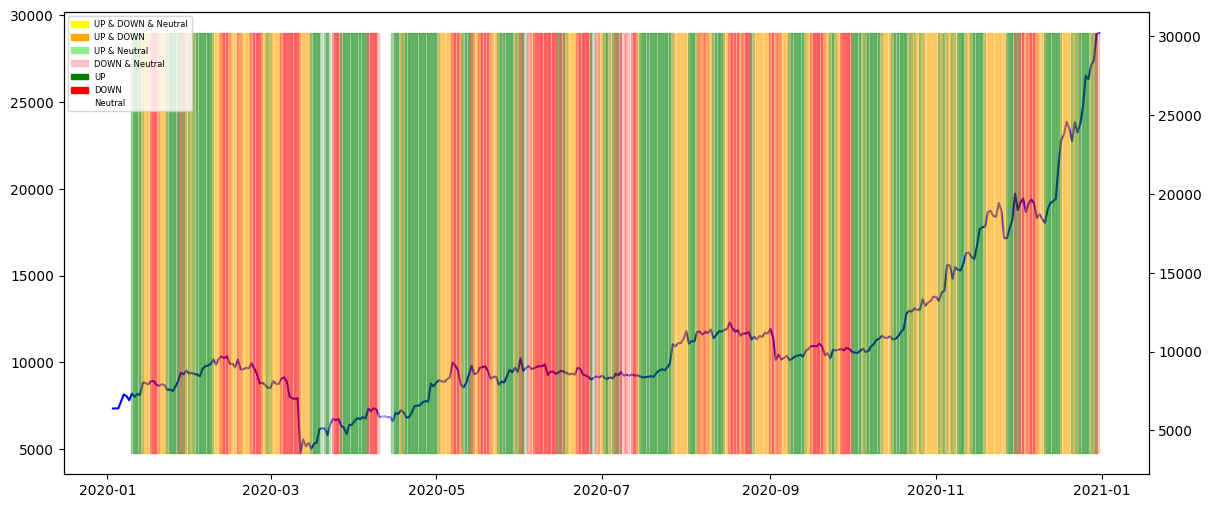

In [28]:
plot_confirmed_labels(conf_df)

### Next day labeling

In [29]:
next_vola_df = triple_barrier_labeling(price_df, volatility_period=7, upper_barrier_factor=0.5, lower_barrier_factor=0.5, vertical_barrier=1, min_trend_days=0, touch_type='close')

In [30]:
next_vola_df.labels.value_counts()

labels
 0    196
 1    104
-1     64
Name: count, dtype: int64

In [31]:
prices = next_vola_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

NameError: name 'band_generator' is not defined

In [37]:
next_ret_df = triple_barrier_labeling(price_df, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=2, min_trend_days=0, barrier_type='returns', touch_type='close')

In [38]:
next_ret_df.labels.value_counts()

labels
 1    168
 0    132
-1     63
Name: count, dtype: int64

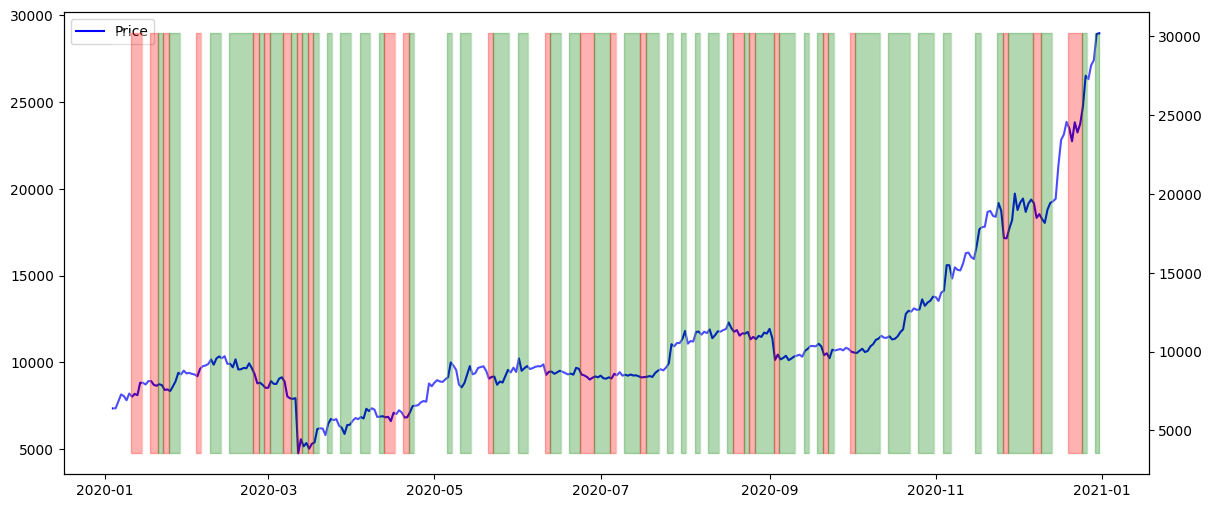

In [39]:
prices = next_ret_df
bands = band_generator(prices.labels)
plot_labels(prices.close, bands)

### Plotting and Visualization

In [40]:
def plot_first_window(df, volatility_period=7, points_before=10, points_after=10):
    """
    Plot the first window in the dataset.
    
    Parameters:
    - df: A pandas DataFrame with 'open', 'high', 'low', 'close', 'upper_barrier', and 'lower_barrier' columns.
    - volatility_period: The number of periods used to calculate volatility.
    - points_before: The number of points before the window to display.
    - points_after: The number of points after the window to display.
    """
    # Find the first window
    first_window_start = df[df['window_start']].index[2]
    first_window_end = df[df['window_start']].index[3] if len(df[df['window_start']]) > 1 else df.index[-1]

    # Calculate the start and end of the plot
    plot_start = max(first_window_start - pd.Timedelta(points_before, unit='D'), df.index[0])
    plot_end = min(first_window_end + pd.Timedelta(points_after, unit='D'), df.index[-1])

    # Extract the data to plot
    plot_data = df.loc[plot_start:plot_end]

    # Create a new Series for window starts
    scatter_series = plot_data['close'].where(plot_data['window_start'])

    # Create additional plots for the upper and lower barriers
    addplot = [mpf.make_addplot(plot_data['upper_barrier'], color='green'),
               mpf.make_addplot(plot_data['lower_barrier'], color='red'),
               # mpf.make_addplot(plot_data['volatility'].rolling(2).mean(), color='yellow'),
               mpf.make_addplot(scatter_series, color='yellow', type='scatter', label="added scatter")]

    # Create a new figure
    fig, axes = mpf.plot(plot_data, type='candle', style='yahoo', addplot=addplot, returnfig=True, figratio=(25,10))
    # Get the axis
    ax = axes[0]
    ax2 = axes[1]

    # ax2.fill_betweenx(ax.get_ylim(), first_window_start, first_window_end, color='green', alpha=0.3)

    # Set x-axis to show every two days
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=45)

    # Add an annotation at the end of the first window
    ax.annotate('Window End', xy=(first_window_end, df.loc[first_window_end, 'close']), xytext=(-15, 15), 
                textcoords='offset points', arrowprops=dict(arrowstyle='->'))

    # Remove grid lines
    ax.grid(False)

    # Show the plot
    plt.show()

In [41]:
tbl_df["day"] = tbl_df.index.date

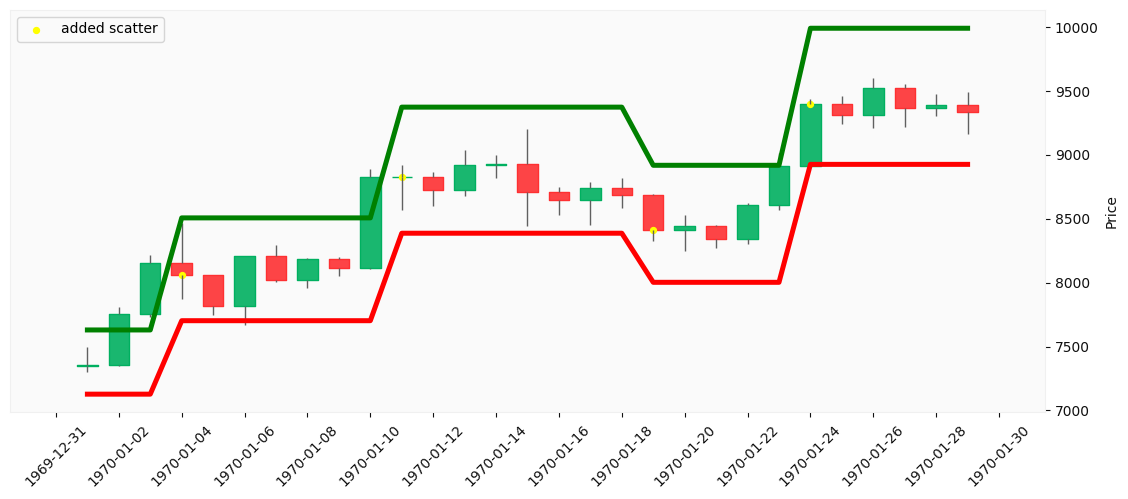

In [42]:
plot_first_window(tbl_df)

In [43]:
dates = tbl_df.index[0:5]
print(dates.to_pydatetime())

# Convert the pandas DatetimeIndex to matplotlib's date format
mpl_dates = mdates.date2num(dates.to_pydatetime())

# Now 'mpl_dates' can be used as input to matplotlib functions
print(mpl_dates)

[datetime.datetime(2020, 1, 4, 0, 0) datetime.datetime(2020, 1, 5, 0, 0)
 datetime.datetime(2020, 1, 6, 0, 0) datetime.datetime(2020, 1, 7, 0, 0)
 datetime.datetime(2020, 1, 8, 0, 0)]
[18265. 18266. 18267. 18268. 18269.]


In [44]:
plt_df = tbl_df["2020-02-10": "2020-03-10"]

In [34]:
class Labeler:
    def __init__(self, name):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        """
        self.name = name

    def fit(self, data):
        """
        Fit the labeler to the data.

        This method should be overridden by subclasses to implement
        the actual fitting logic.

        Args:
        data (any): The data to fit the labeler to.
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def transform(self, data):
        """
        Transform the data into labels.

        This method should be overridden by subclasses to implement
        the actual transformation logic.

        Args:
        data (any): The data to transform into labels.

        Returns:
        any: The labels.
        """
        raise NotImplementedError("Subclasses must implement this method.")

class TripleBarrierLabeler(Labeler):
    def __init__(self, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL", up_label=2, neutral_label=1, down_label=0):
        """
        Initialize the labeler.
        """
        super().__init__(name="triple barrier labeling")
        self.volatility_period = volatility_period
        self.upper_barrier_factor = upper_barrier_factor
        self.lower_barrier_factor = lower_barrier_factor
        self.vertical_barrier = vertical_barrier
        self.min_trend_days = min_trend_days
        self.barrier_type = barrier_type
        self.touch_type = touch_type
        self.up_label = up_label
        self.down_label = down_label
        self.neutral_label = neutral_label

    def calculate_barriers(self, df, i, window):
        """calculate the barriers based on either volatility or returns of the backward window

        Args:
            df (pd.DataFrame): Data
            i (pd.index): the index of the beginning of the window
            window (int): window size

        Returns:
            df: Data including barriers for the forward window
        """
        end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

        # Calculate the mean volatility or daily returns over the volatility_period
        if self.barrier_type == 'volatility':
            current_value = df.loc[i, 'volatility']
        elif self.barrier_type == 'returns':
            current_value = df.loc[i, 'daily_returns']
        else:
            raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

        df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * self.upper_barrier_factor)
        df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * self.lower_barrier_factor)
        return df

    def label_observations(self, df, origin, i, label):
        df.loc[origin:i+1, 'label'] = label
        return df

    def get_daily_vol(self, close, span0=100):
        """
        Calculate the daily volatility of closing prices.

        Parameters:
        - close: A pandas Series of closing prices.
        - span0: The span for the EWM standard deviation.

        Returns:
        - A pandas Series of daily volatility estimates.
        """
        # Find the start of the previous day for each day
        prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
        prev_day_start = prev_day_start[prev_day_start > 0]

        # Create a series with the start of the previous day for each day
        prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

        # Calculate daily returns
        daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

        # Calculate EWM standard deviation of daily returns
        daily_vol = daily_returns.ewm(span=span0).std()

        return daily_returns, daily_vol

    def fit(self, sdf):
        df = sdf.copy()
        # Calculate daily returns and volatility
        df['daily_returns'], df['volatility'] = self.get_daily_vol(df.close, self.volatility_period)

        df = df.reset_index()
        # Initialize label and window start
        df['label'] = self.neutral_label
        df['window_start'] = False

        self.data = df

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        window = self.vertical_barrier
        origin = 0
        touch_upper = lambda high, barrier: high >= barrier
        touch_lower = lambda low, barrier: low <= barrier
        # For each observation
        for i in range(0, len(self.data)):
            # Define your barriers at the beginning of each window
            if i == origin:
                self.data = self.calculate_barriers(self.data, i, window)
                self.data.loc[i, 'window_start'] = True  # Mark the start of the window

            # one of the conditions were met
            if touch_upper(self.data.loc[i, "high" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "upper_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.up_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier
            elif touch_lower(self.data.loc[i, "low" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "lower_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.down_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier

            # none of the conditions were met
            else:
                if window > 0:
                    # reduce window size by one
                    window = window - 1
                else:
                    # reset window
                    window = self.vertical_barrier
                    # label neutral from origin to origin + window
                    self.data.loc[origin:min(origin+window, len(self.data)-1), 'label'] = self.neutral_label  # Ensure the window does not exceed the dataframe
                    # set origin to the next id
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index

        self.data = self.data.set_index("timestamp")
        return self.data

def optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=10, optimization_interval='6M'):
    if optimization_interval is None:
        # Use the whole dataset for optimization
        best_params, best_sharpe_ratio = tune_hyperparameters_scipy(price_df, param_grid, initial_capital, num_starts)
        return pd.DataFrame([{
            'start': price_df.index[0],
            'end': price_df.index[-1],
            'params': best_params,
            'sharpe_ratio': best_sharpe_ratio,
        }])
    else:
        # Optimize parameters at specified intervals
        intervals = pd.date_range(start=price_df.index[0], end=price_df.index[-1], freq=optimization_interval)
        optimized_params = []

        for start, end in zip(intervals[:-1], intervals[1:]):
            interval_df = price_df.loc[start:end]
            best_params, best_sharpe_ratio = tune_hyperparameters_scipy(interval_df, param_grid, initial_capital, num_starts)
            optimized_params.append({
                'start': start,
                'end': end,
                'params': best_params,
                'sharpe_ratio': best_sharpe_ratio,
            })

        return pd.DataFrame(optimized_params)

def tune_hyperparameters_scipy(price_df, param_grid, initial_capital=100000, num_starts=10):
    best_sharpe_ratio, best_net_profit, best_params = -np.inf, -np.inf, None

    param_space = [
        param_grid['volatility_period'],
        param_grid['upper_barrier_factor'],
        param_grid['lower_barrier_factor'],
        param_grid['vertical_barrier'],
        param_grid['barrier_type'],
        param_grid['touch_type']
    ]

    bounds = [(0, len(space) - 1) for space in param_space]

    def bounds_to_params(x):
        return {key: space[int(idx)] for key, space, idx in zip(param_grid.keys(), param_space, x)}

    def objective_wrapper(x):
        params = bounds_to_params(x)
        return sharpe_ratio_objective(params, price_df, initial_capital)

    for _ in tqdm(range(num_starts), desc="Optimizing"):
        initial_guess = [np.random.randint(len(space)) for space in param_space]
        result = minimize(objective_wrapper, initial_guess, method='SLSQP', bounds=bounds)

        if result.success and -result.fun > best_sharpe_ratio:
            best_sharpe_ratio = -result.fun
            best_params = bounds_to_params(result.x)

    return best_params, best_sharpe_ratio

def sharpe_ratio_objective(params, price_df, initial_capital):
    labeler = TripleBarrierLabeler(**params)
    labeler.fit(price_df)
    labeled_df = labeler.transform()
    labeled_df.set_index(price_df.index, inplace=True)
    sharpe_ratio = strategize_and_measure(labeled_df, init_capital=initial_capital)
    return -sharpe_ratio  # Minimize negative Sharpe Ratio to maximize Sharpe Ratio

def strategize_and_measure(price_df, init_capital=1000, fee=0.006):
    entries = price_df["label"] > 1
    short_entries = price_df["label"] < 1
    # Calculate the percentage changes for TP and SL
    price_df['tp_stop'] = (price_df['upper_barrier'] - price_df['close']) / price_df['close']
    price_df['sl_stop'] = (price_df['close'] - price_df['lower_barrier']) / price_df['close']
    # Replace negative values with 0
    price_df['tp_stop'] = price_df['tp_stop'].apply(lambda x: max(x, 0))
    price_df['sl_stop'] = price_df['sl_stop'].apply(lambda x: max(x, 0))

    # Run the backtest
    pf = vbt.Portfolio.from_signals(
        close=price_df['close'],
        entries=entries,
        short_entries=short_entries,
        # size=size,
        tp_stop=price_df['tp_stop'],
        sl_stop=price_df['sl_stop'],
        init_cash=1000,  # Initial cash value
        fees=fee,  # Commission fees (0.5%)
        freq="D"
    )

    return pf.sharpe_ratio()

def compute_metrics_classification(labels, preds, probs, metrics_to_return=None):
    """
    Compute classification metrics based on the model's predictions and the true labels.

    Args:
    labels (any): The true labels.
    preds (any): The model's predictions.
    probs (any): The model's probabilities
    metrics_to_return (list): List of metric names to compute and return.

    Returns:
    dict: The computed classification metrics.
    """
    if metrics_to_return is None:
        metrics_to_return = ["accuracy", "f1", "precision", "recall", "roc_score", "confusion_matrix"]

    metrics = {}

    if "precision" in metrics_to_return or "recall" in metrics_to_return or "f1" in metrics_to_return:
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
        if "precision" in metrics_to_return:
            metrics["precision"] = precision
        if "recall" in metrics_to_return:
            metrics["recall"] = recall
        if "f1" in metrics_to_return:
            metrics["f1"] = f1

    if "accuracy" in metrics_to_return:
        metrics["accuracy"] = accuracy_score(labels, preds)

    if "roc_score" in metrics_to_return:
        metrics["roc_score"] = roc_auc_score(labels, probs, multi_class='ovr')

    if "confusion_matrix" in metrics_to_return:
        metrics["confusion_matrix"] = confusion_matrix(labels, preds)

    return metrics


def pandas_data_loader(addr: str, columns: List[str], *transforms: Callable[[pd.DataFrame], pd.DataFrame]) -> pd.DataFrame:
    # Load the data from the CSV file
    df = pd.read_csv(addr, usecols=columns)

    # Apply each transform to the DataFrame
    for transform in transforms:
        df = transform(df)

    return df

# Transform index to datetime
def index_to_datetime(df, unit="s"):
    df.index = pd.to_datetime(df.index, unit=unit)
    return df
# Transform col to index
to_index = lambda col, df: df.set_index(col)
# Rename text_plit to text
rename = lambda original, new, df: df.rename(columns={original: new})

In [45]:
# # Define the parameter grid
# param_grid = {
#     'volatility_period': [7, 8, 9, 10, 11, 12, 13, 14, 15],
#     'upper_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
#     'lower_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
#     'vertical_barrier': [7, 8, 9, 10, 11, 12, 13, 14, 15],
#     'barrier_type': ['volatility'],
#     'touch_type': ['HL']
# }

# # Optimize parameters every six months
# optimized_params_df = optimize_parameters(price_df, param_grid, initial_capital=100000, num_starts=100, optimization_interval="6M")
# # Apply the optimized parameters to label the data
# labeled_df = pd.DataFrame()
# for _, row in optimized_params_df.iterrows():
#     start, end, params = row['start'], row['end'], row['params']
#     interval_df = price_df.loc[start:end]
#     labeler = TripleBarrierLabeler(**params)
#     labeler.fit(interval_df)
#     labeled_interval_df = labeler.transform()
#     labeled_df = pd.concat([labeled_df, labeled_interval_df])

# # Check the label distribution
# print(labeled_df.label.value_counts(), optimized_params_df.sharpe_ratio)

Optimizing:   0%|          | 0/100 [00:00<?, ?it/s]

label
2    96
0    45
1    42
Name: count, dtype: int64 0    4.613233
Name: sharpe_ratio, dtype: float64


In [59]:
# @title load price data
address = "../raw/optimized_labeled.csv" # @param {"type":"string","placeholder":"./raw/daily-2020.csv"}
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume", "label", "window_start", "upper_barrier", "lower_barrier"]
labeled_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), partial(index_to_datetime, unit=None))
labeled_df = labeled_df.sort_index()

In [60]:
labeled_df = labeled_df.dropna()

In [61]:
labeled_df["day"] = labeled_df.index.date

In [62]:
labeled_df["return"], labeled_df["volatility"] = get_volatility_and_return(labeled_df.close)

In [63]:
labeled_df.tail()

,open,high,low,close,volume,label,window_start,upper_barrier,lower_barrier,day,return,volatility
timestamp,,,,,,,,,,,,
2024-01-27,41806.4,42187.1,41360.1,42102.2,118437.114,2,True,44375.18597,39991.570171,2024-01-27,0.007051,0.027073
2024-01-28,42102.2,42836.0,41600.0,42021.2,205736.453,1,False,44375.18597,39991.570171,2024-01-28,-0.001926,0.026190
2024-01-29,42021.2,43340.8,41768.3,43287.7,249502.110,1,False,44375.18597,39991.570171,2024-01-29,0.029694,0.026404
2024-01-30,43287.6,43888.0,42665.6,42918.3,257582.784,1,False,44375.18597,39991.570171,2024-01-30,-0.008570,0.025669
2024-01-31,42918.3,43748.6,42257.6,42560.5,313069.110,1,False,44375.18597,39991.570171,2024-01-31,-0.008372,0.024941


In [69]:
plt_df = labeled_df.loc["2020-04-26": "2020-05-31"]

/tmp/ipykernel_4808/202560449.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_df['day'] = pd.to_datetime(plt_df['day'])
/tmp/ipykernel_4808/202560449.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  upper_series.iloc[0] = plt_df['close'][branch_point]
/tmp/ipykernel_4808/202560449.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_series.iloc[0] = plt_df['cl

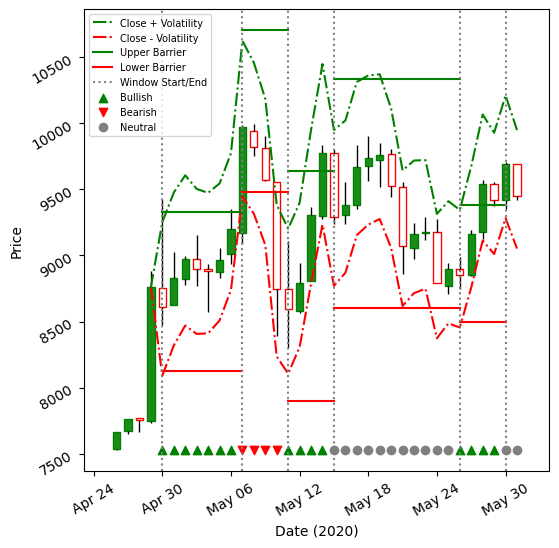

In [73]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
from matplotlib.ticker import MaxNLocator

# Convert 'day' column to datetime and set it as the index
plt_df['day'] = pd.to_datetime(plt_df['day'])
ohlc_df = plt_df[['day', 'open', 'high', 'low', 'close']].copy()
ohlc_df.set_index('day', inplace=True)

# Plot the candlestick chart
fig, ax = plt.subplots(figsize=(6, 6), facecolor="none")
mc = mpf.make_marketcolors(up='g', down='none',
                           edge={'up':'g', 'down':'r'},
                           ohlc='black')
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(ohlc_df, type='candle', ax=ax, style=s, show_nontrading=True)

# Branch out into three lines at a specific point (e.g., day 20)
branch_point = 3

# Calculate the adjusted values
upper_series = plt_df['close'][branch_point:] + plt_df['close'][branch_point:] * plt_df['volatility'][branch_point:] * 1.5
lower_series = plt_df['close'][branch_point:] - plt_df['close'][branch_point:] * plt_df['volatility'][branch_point:] * 1.2

# Ensure the first point is equal to the close price
upper_series.iloc[0] = plt_df['close'][branch_point]
lower_series.iloc[0] = plt_df['close'][branch_point]

# Plot the adjusted values
ax.plot(plt_df['day'][branch_point:], upper_series, color="green", linestyle='-.', label='Close + Volatility')
ax.plot(plt_df['day'][branch_point:], lower_series, color='red', linestyle='-.', label='Close - Volatility')

# Loop through the windows and plot the barriers
window_starts = plt_df.iloc[branch_point:][plt_df.window_start].index
labels = {'Upper Barrier': False, 'Lower Barrier': False, 'Window Start/End': False}

for current_start, next_start in zip(window_starts[:-1], window_starts[1:]):
    # Upper barrier line
    ax.plot([plt_df['day'][current_start], plt_df['day'][next_start]], 
             [plt_df['upper_barrier'][current_start], plt_df['upper_barrier'][current_start]], 
             color='green', label='Upper Barrier' if not labels['Upper Barrier'] else "")
    labels['Upper Barrier'] = True

    # Lower barrier line
    ax.plot([plt_df['day'][current_start], plt_df['day'][next_start]], 
             [plt_df['lower_barrier'][current_start], plt_df['lower_barrier'][current_start]], 
             color='red', label='Lower Barrier' if not labels['Lower Barrier'] else "")
    labels['Lower Barrier'] = True

    # Vertical barriers
    ax.axvline(x=plt_df['day'][current_start], color='grey', linestyle=':', label='Window Start/End' if not labels['Window Start/End'] else "")
    labels['Window Start/End'] = True

ax.axvline(x=plt_df['day'][next_start], color='grey', linestyle=':', label="")

# Adding scatters for labels
min_low = plt_df['low'].min()
for i, row in plt_df[branch_point + 1:].iterrows():
    if row['label'] == 0:
        ax.scatter(row['day'], min_low, marker="v", color='red', label='Bearish' if 'Bearish' not in ax.get_legend_handles_labels()[1] else "")
    elif row['label'] == 1:
        ax.scatter(row['day'], min_low, color='grey', label='Neutral' if 'Neutral' not in ax.get_legend_handles_labels()[1] else "")
    elif row['label'] == 2:
        ax.scatter(row['day'], min_low, marker="^", color='green', label='Bullish' if 'Bullish' not in ax.get_legend_handles_labels()[1] else "")

# Add labels and legend
ax.grid(False)
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.xlabel('Date (2020)')
plt.ylabel('Price')
plt.title('')
plt.legend(prop={"size": 7})

# Specify the number of x-ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=7))  # Change '10' to the number of x-ticks you want

plt.savefig('TBL.png')
plt.show()

In [67]:
plt_df = labeled_df.loc["2020-03-10": "2020-06-10"]

/tmp/ipykernel_25705/1871285941.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plt_df['day'] = pd.to_datetime(plt_df['day'])
/tmp/ipykernel_25705/1871285941.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  upper_series.iloc[0] = plt_df['close'][branch_point]
/tmp/ipykernel_25705/1871285941.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lower_series.iloc[0] = plt_

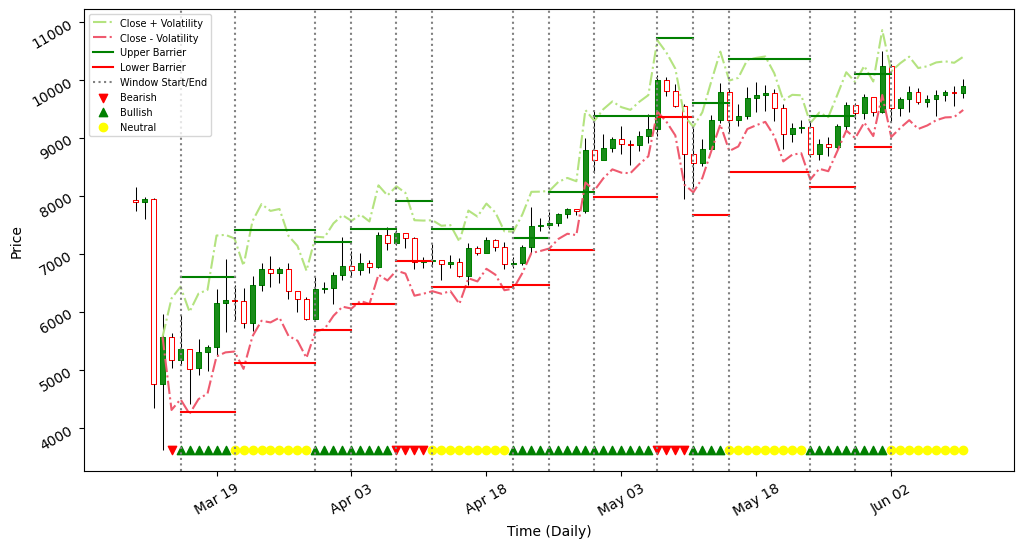

In [24]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
from matplotlib.ticker import MaxNLocator

# Convert 'day' column to datetime and set it as the index
plt_df['day'] = pd.to_datetime(plt_df['day'])
ohlc_df = plt_df[['day', 'open', 'high', 'low', 'close']].copy()
ohlc_df.set_index('day', inplace=True)

# Plot the candlestick chart
fig, ax = plt.subplots(figsize=(12, 6), facecolor="none")
mc = mpf.make_marketcolors(up='g', down='none',
                           edge={'up':'g', 'down':'r'},
                           ohlc='black')
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(ohlc_df, type='candle', ax=ax, style=s, show_nontrading=True)

# Branch out into three lines at a specific point (e.g., day 20)
branch_point = 3

# Calculate the adjusted values
upper_series = plt_df['close'][branch_point:] + plt_df['close'][branch_point:] * plt_df['volatility'][branch_point:] * 1.5
lower_series = plt_df['close'][branch_point:] - plt_df['close'][branch_point:] * plt_df['volatility'][branch_point:] * 1.2

# Ensure the first point is equal to the close price
upper_series.iloc[0] = plt_df['close'][branch_point]
lower_series.iloc[0] = plt_df['close'][branch_point]

# Plot the adjusted values
ax.plot(plt_df['day'][branch_point:], upper_series, color="#B4E380", linestyle='-.', label='Close + Volatility')
ax.plot(plt_df['day'][branch_point:], lower_series, color='#EF5A6F', linestyle='-.', label='Close - Volatility')

# Loop through the windows and plot the barriers
window_starts = plt_df.iloc[branch_point:][plt_df.window_start].index
labels = {'Upper Barrier': False, 'Lower Barrier': False, 'Window Start/End': False}

for current_start, next_start in zip(window_starts[:-1], window_starts[1:]):
    # Upper barrier line
    ax.plot([plt_df['day'][current_start], plt_df['day'][next_start]], 
             [plt_df['upper_barrier'][current_start], plt_df['upper_barrier'][current_start]], 
             color='green', label='Upper Barrier' if not labels['Upper Barrier'] else "")
    labels['Upper Barrier'] = True

    # Lower barrier line
    ax.plot([plt_df['day'][current_start], plt_df['day'][next_start]], 
             [plt_df['lower_barrier'][current_start], plt_df['lower_barrier'][current_start]], 
             color='red', label='Lower Barrier' if not labels['Lower Barrier'] else "")
    labels['Lower Barrier'] = True

    # Vertical barriers
    ax.axvline(x=plt_df['day'][current_start], color='grey', linestyle=':', label='Window Start/End' if not labels['Window Start/End'] else "")
    labels['Window Start/End'] = True

ax.axvline(x=plt_df['day'][next_start], color='grey', linestyle=':', label="")

# Adding scatters for labels
min_low = plt_df['low'].min()
for i, row in plt_df[branch_point + 1:].iterrows():
    if row['label'] == 0:
        ax.scatter(row['day'], min_low, marker="v", color='red', label='Bearish' if 'Bearish' not in ax.get_legend_handles_labels()[1] else "")
    elif row['label'] == 1:
        ax.scatter(row['day'], min_low, color='yellow', label='Neutral' if 'Neutral' not in ax.get_legend_handles_labels()[1] else "")
    elif row['label'] == 2:
        ax.scatter(row['day'], min_low, marker="^", color='green', label='Bullish' if 'Bullish' not in ax.get_legend_handles_labels()[1] else "")

# Add labels and legend
ax.grid(False)
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.xlabel('Time (Daily)')
plt.ylabel('Price')
plt.title('')
plt.legend(prop={"size": 7})

# Specify the number of x-ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=7))  # Change '10' to the number of x-ticks you want

plt.savefig('TBL.png')
plt.show()


In [138]:
price_df["day"] = price_df.index.date

In [139]:
plt_df = price_df.loc["2020-03-10": "2020-06-10"]

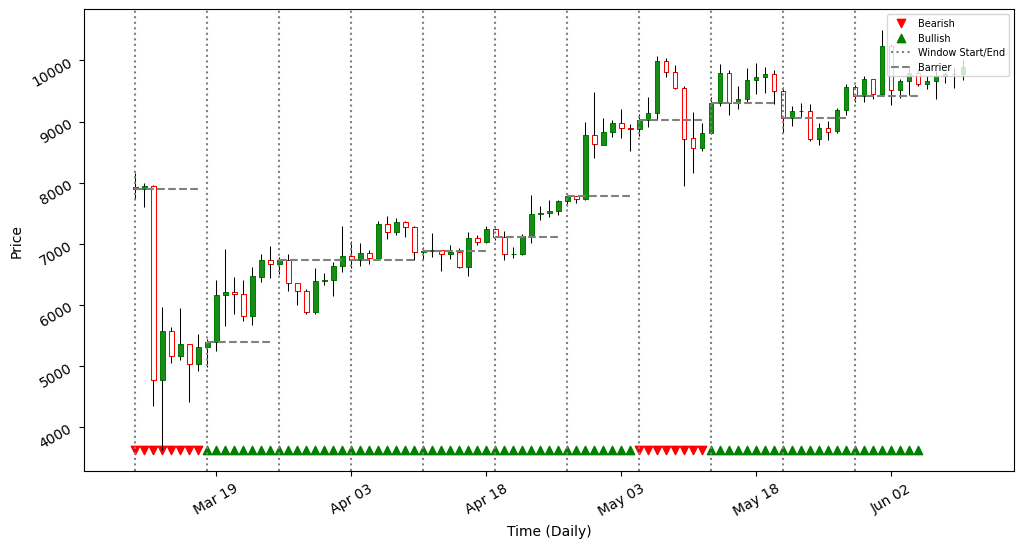

In [32]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
from matplotlib.ticker import MaxNLocator

def fixed_time_horizon_labeling(price_series, h):
    """
    Perform fixed time horizon labeling on a price series.
    
    Parameters:
    - price_series: A pandas Series of prices.
    - h: The bar horizon.
    
    Returns:
    - A pandas Series of labels (-1, 1).
    - A list of start indices for each window.
    - A list of barrier values for each window.
    """
    # Split the price series into non-overlapping windows of size h
    windows = [price_series[i:i+h] for i in range(0, len(price_series), h)]
    
    # Initialize lists to store the labels, start indices, and barriers
    labels = []
    start_indices = []
    barriers = []
    
    # For each window, compare the last item with the first item and assign a label accordingly
    for i, window in enumerate(windows):
        if len(window) == h:  # Ensure the window is of size h
            start_indices.append(window.index[0])
            barriers.append(window.iloc[0])
            if window.iloc[-1] > window.iloc[0]:
                labels.extend([1]*h)  # Bullish
            elif window.iloc[-1] < window.iloc[0]:
                labels.extend([-1]*h)  # Bearish
    
    # Convert the list of labels into a pandas Series
    labels = pd.Series(labels, index=price_series.index[:len(labels)])
    
    return labels, start_indices, barriers

# Convert 'day' column to datetime and set it as the index
plt_df.loc[:, 'day'] = pd.to_datetime(plt_df['day'])
ohlc_df = plt_df[['day', 'open', 'high', 'low', 'close']].copy()
ohlc_df.set_index('day', inplace=True)

# Plot the candlestick chart
fig, ax = plt.subplots(figsize=(12, 6), facecolor="none")
mc = mpf.make_marketcolors(up='g', down='none',
                           edge={'up':'g', 'down':'r'},
                           ohlc='black')
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(ohlc_df, type='candle', ax=ax, style=s, show_nontrading=True)

# Define the fixed window size
window_size = 8

# Label the data using the fixed time horizon labeling function
labels, start_indices, barriers = fixed_time_horizon_labeling(plt_df['close'], window_size)
plt_df.loc[:, 'label'] = labels

# Adding scatters for labels
min_low = plt_df['low'].min()
for i, row in plt_df.iterrows():
    if row['label'] == -1:
        ax.scatter(row['day'], min_low, marker="v", color='red', label='Bearish' if 'Bearish' not in ax.get_legend_handles_labels()[1] else "")
    elif row['label'] == 1:
        ax.scatter(row['day'], min_low, marker="^", color='green', label='Bullish' if 'Bullish' not in ax.get_legend_handles_labels()[1] else "")

# Plot vertical barriers at the start of each window
labels_dict = {'Window Start/End': False}
for start_index, barrier in zip(start_indices, barriers):
    ax.axvline(x=plt_df['day'].loc[start_index], color='grey', linestyle=':', label='Window Start/End' if not labels_dict['Window Start/End'] else "")
    labels_dict['Window Start/End'] = True
    end_index = start_index + pd.DateOffset(days=window_size - 1)
    ax.plot([plt_df['day'].loc[start_index], plt_df['day'].loc[end_index]], 
            [barrier, barrier], color='gray', linestyle='--', label='Barrier' if 'Barrier' not in ax.get_legend_handles_labels()[1] else "")

# Add labels and legend
ax.grid(False)
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.xlabel('Time (Daily)')
plt.ylabel('Price')
plt.title('')
plt.legend(prop={"size": 7})

# Specify the number of x-ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=7))  # Change '10' to the number of x-ticks you want

plt.savefig('fixed_windows.png')
plt.show()


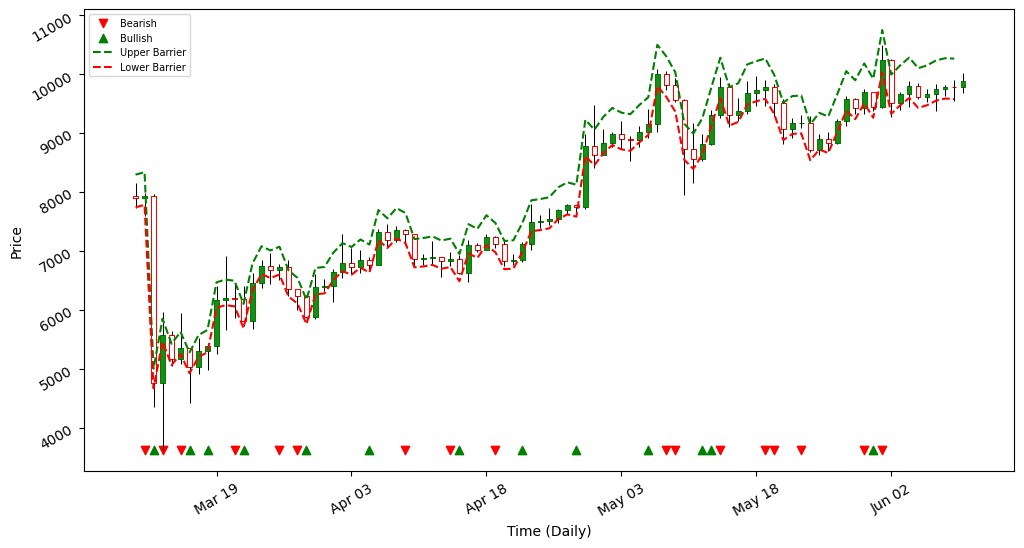

In [33]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
from matplotlib.ticker import MaxNLocator
from bidi.algorithm import get_display
from arabic_reshaper import reshape

def fixed_threshold_labeling(price_series, up_threshold=0.05, down_threshold=0.02):
    """
    Perform fixed threshold labeling on a price series.
    
    Parameters:
    - price_series: A pandas Series of prices.
    - up_threshold: The upward threshold for labeling as bullish.
    - down_threshold: The downward threshold for labeling as bearish.
    
    Returns:
    - A pandas Series of labels (-1, 1).
    - A pandas Series of upper barriers.
    - A pandas Series of lower barriers.
    """
    # Initialize lists to store the labels and barriers
    labels = [0] * len(price_series)
    upper_barriers = [None] * len(price_series)
    lower_barriers = [None] * len(price_series)
    
    # Loop through the price series and apply the thresholds
    for i in range(1, len(price_series)):
        change = (price_series.iloc[i] - price_series.iloc[i-1]) / price_series.iloc[i-1]
        upper_barriers[i-1] = price_series.iloc[i-1] * (1 + up_threshold)
        lower_barriers[i-1] = price_series.iloc[i-1] * (1 - down_threshold)
        if change >= up_threshold:
            labels[i-1] = 1  # Bullish
        elif change <= -down_threshold:
            labels[i-1] = -1  # Bearish
    
    # Convert the lists into pandas Series
    labels = pd.Series(labels, index=price_series.index)
    upper_barriers = pd.Series(upper_barriers, index=price_series.index)
    lower_barriers = pd.Series(lower_barriers, index=price_series.index)
    
    return labels, upper_barriers, lower_barriers


import matplotlib.pyplot as plt
import mplfinance as mpf
import pandas as pd
from matplotlib.ticker import MaxNLocator

# Convert 'day' column to datetime and set it as the index
plt_df.loc[:, 'day'] = pd.to_datetime(plt_df['day'])
ohlc_df = plt_df[['day', 'open', 'high', 'low', 'close']].copy()
ohlc_df.set_index('day', inplace=True)

# Plot the candlestick chart
fig, ax = plt.subplots(figsize=(12, 6), facecolor="none")
mc = mpf.make_marketcolors(up='g', down='none',
                           edge={'up':'g', 'down':'r'},
                           ohlc='black')
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(ohlc_df, type='candle', ax=ax, style=s, show_nontrading=True)

# Label the data using the fixed threshold labeling function
labels, upper_barriers, lower_barriers = fixed_threshold_labeling(plt_df['close'], up_threshold=0.05, down_threshold=0.02)
plt_df.loc[:, 'label'] = labels
plt_df.loc[:, 'upper_barrier'] = upper_barriers
plt_df.loc[:, 'lower_barrier'] = lower_barriers

# Adding scatters for labels
min_low = plt_df['low'].min()
for i, row in plt_df.iterrows():
    if row['label'] == -1:
        ax.scatter(row['day'], min_low, marker="v", color='red', label='Bearish' if 'Bearish' not in ax.get_legend_handles_labels()[1] else "")
    elif row['label'] == 1:
        ax.scatter(row['day'], min_low, marker="^", color='green', label='Bullish' if 'Bullish' not in ax.get_legend_handles_labels()[1] else "")

# Plot the upper and lower barriers
ax.plot(plt_df['day'], plt_df['upper_barrier'], color='green', linestyle='--', label='Upper Barrier')
ax.plot(plt_df['day'], plt_df['lower_barrier'], color='red', linestyle='--', label='Lower Barrier')

# Add labels and legend
ax.grid(False)
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.xlabel('Time (Daily)')
plt.ylabel('Price')
plt.title('')
plt.legend(prop={"size": 7})

# Specify the number of x-ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=7))  # Change '10' to the number of x-ticks you want

plt.savefig('fixed_threshold.png')
plt.show()

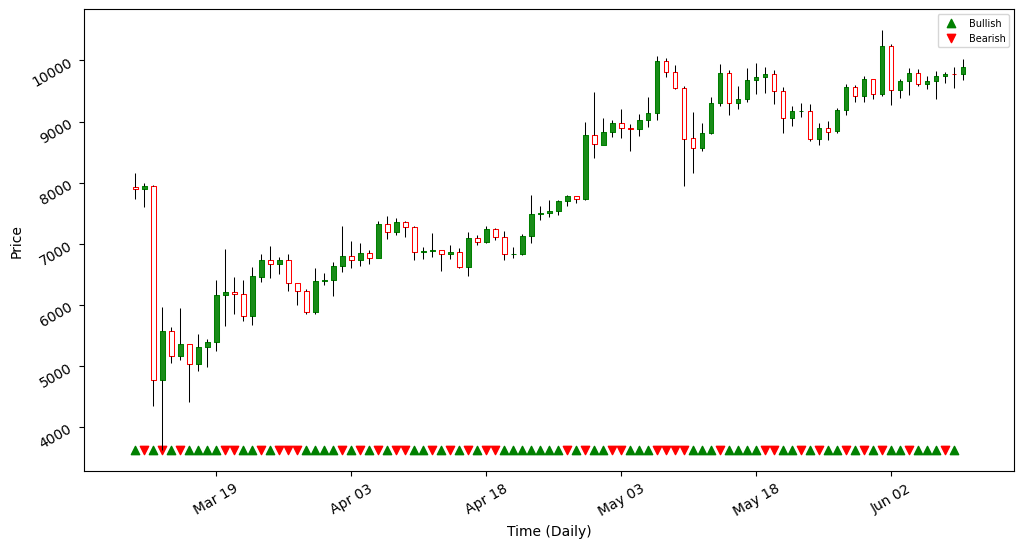

In [34]:
def previous_bar_labeling(price_series):
    """
    Perform labeling based on the previous bar's close price.
    
    Parameters:
    - price_series: A pandas Series of prices.
    
    Returns:
    - A pandas Series of labels (-1, 1).
    """
    # Initialize an empty list to store the labels
    labels = [0] * len(price_series)
    
    # Loop through the price series and compare with the previous bar
    for i in range(1, len(price_series)):
        if price_series.iloc[i] > price_series.iloc[i-1]:
            labels[i-1] = 1  # Bullish
        else:
            labels[i-1] = -1  # Bearish
    
    # Convert the list of labels into a pandas Series
    labels = pd.Series(labels, index=price_series.index)
    
    return labels

# Convert 'day' column to datetime and set it as the index
plt_df.loc[:, 'day'] = pd.to_datetime(plt_df['day'])
ohlc_df = plt_df[['day', 'open', 'high', 'low', 'close']].copy()
ohlc_df.set_index('day', inplace=True)

# Plot the candlestick chart
fig, ax = plt.subplots(figsize=(12, 6), facecolor="none")
mc = mpf.make_marketcolors(up='g', down='none',
                           edge={'up':'g', 'down':'r'},
                           ohlc='black')
s = mpf.make_mpf_style(marketcolors=mc)
mpf.plot(ohlc_df, type='candle', ax=ax, style=s, show_nontrading=True)

# Label the data using the previous bar labeling function
labels = previous_bar_labeling(plt_df['close'])
plt_df.loc[:, 'label'] = labels

# Adding scatters for labels
min_low = plt_df['low'].min()
for i, row in plt_df.iterrows():
    if row['label'] == -1:
        ax.scatter(row['day'], min_low, marker="v", color='red', label='Bearish' if 'Bearish' not in ax.get_legend_handles_labels()[1] else "")
    elif row['label'] == 1:
        ax.scatter(row['day'], min_low, marker="^", color='green', label='Bullish' if 'Bullish' not in ax.get_legend_handles_labels()[1] else "")

# Add labels and legend
ax.grid(False)
plt.xticks(rotation=30)
plt.yticks(rotation=30)
plt.xlabel('Time (Daily)')
plt.ylabel('Price')
plt.title('')
plt.legend(prop={"size": 7})

# Specify the number of x-ticks
ax.xaxis.set_major_locator(MaxNLocator(nbins=7))  # Change '10' to the number of x-ticks you want

plt.savefig('ROC_next_day.png')
plt.show()

